In [18]:
sc.setLogLevel("ERROR")
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
import pandas as pd
import matplotlib.pyplot as plt 


   # Создаем SparkSession
spark = SparkSession.builder.appName("SmokeDetection").getOrCreate()

   # Загружаем данные с помощью Pandas
#pandas_df = pd.read_csv("hdfs:/user/student/smoke_detection_iot.csv")
  # Загружаем данные с помощ spark
df = spark.read.option("sep", ",").csv("smoke_detection_iot.csv", header = "True", inferSchema=True) 

df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- UTC: integer (nullable = true)
 |-- Temperature[C]: double (nullable = true)
 |-- Humidity[%]: double (nullable = true)
 |-- TVOC[ppb]: integer (nullable = true)
 |-- eCO2[ppm]: integer (nullable = true)
 |-- Raw H2: integer (nullable = true)
 |-- Raw Ethanol: integer (nullable = true)
 |-- Pressure[hPa]: double (nullable = true)
 |-- PM1.0: double (nullable = true)
 |-- PM2.5: double (nullable = true)
 |-- NC0.5: double (nullable = true)
 |-- NC1.0: double (nullable = true)
 |-- NC2.5: double (nullable = true)
 |-- CNT: integer (nullable = true)
 |-- Fire Alarm: integer (nullable = true)



In [19]:
df = df.withColumnRenamed("_c0", "ID").withColumnRenamed("Temperature[C]", "Temperature").withColumnRenamed("TVOC[ppb]", "TVOC") \
    .withColumnRenamed("Humidity[%]", "Humidity").withColumnRenamed("eCO2[ppm]", "eCO2").withColumnRenamed("Raw H2", "Raw_H2") \
    .withColumnRenamed("Raw Ethanol", "Raw_Ethanol").withColumnRenamed("Pressure[hPa]", "Pressure").withColumnRenamed("PM1.0", "PM1_0") \
    .withColumnRenamed("PM2.5", "PM2_5").withColumnRenamed("NC0.5", "NC0_5").withColumnRenamed("NC1.0", "NC1_0") \
    .withColumnRenamed("NC2.5", "NC2_5")
    

df.printSchema()
df.drop('UTC').show(5)

root
 |-- ID: integer (nullable = true)
 |-- UTC: integer (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Humidity: double (nullable = true)
 |-- TVOC: integer (nullable = true)
 |-- eCO2: integer (nullable = true)
 |-- Raw_H2: integer (nullable = true)
 |-- Raw_Ethanol: integer (nullable = true)
 |-- Pressure: double (nullable = true)
 |-- PM1_0: double (nullable = true)
 |-- PM2_5: double (nullable = true)
 |-- NC0_5: double (nullable = true)
 |-- NC1_0: double (nullable = true)
 |-- NC2_5: double (nullable = true)
 |-- CNT: integer (nullable = true)
 |-- Fire Alarm: integer (nullable = true)

+---+-----------+--------+----+----+------+-----------+--------+-----+-----+-----+-----+-----+---+----------+
| ID|Temperature|Humidity|TVOC|eCO2|Raw_H2|Raw_Ethanol|Pressure|PM1_0|PM2_5|NC0_5|NC1_0|NC2_5|CNT|Fire Alarm|
+---+-----------+--------+----+----+------+-----------+--------+-----+-----+-----+-----+-----+---+----------+
|  0|       20.0|   57.36|   0| 400| 12306|      

In [20]:
data = df.drop('ID', 'UTC', 'CNT')
feature_cols = data.drop('Fire Alarm')

data.show(5)

+-----------+--------+----+----+------+-----------+--------+-----+-----+-----+-----+-----+----------+
|Temperature|Humidity|TVOC|eCO2|Raw_H2|Raw_Ethanol|Pressure|PM1_0|PM2_5|NC0_5|NC1_0|NC2_5|Fire Alarm|
+-----------+--------+----+----+------+-----------+--------+-----+-----+-----+-----+-----+----------+
|       20.0|   57.36|   0| 400| 12306|      18520| 939.735|  0.0|  0.0|  0.0|  0.0|  0.0|         0|
|     20.015|   56.67|   0| 400| 12345|      18651| 939.744|  0.0|  0.0|  0.0|  0.0|  0.0|         0|
|     20.029|   55.96|   0| 400| 12374|      18764| 939.738|  0.0|  0.0|  0.0|  0.0|  0.0|         0|
|     20.044|   55.28|   0| 400| 12390|      18849| 939.736|  0.0|  0.0|  0.0|  0.0|  0.0|         0|
|     20.059|   54.69|   0| 400| 12403|      18921| 939.744|  0.0|  0.0|  0.0|  0.0|  0.0|         0|
+-----------+--------+----+----+------+-----------+--------+-----+-----+-----+-----+-----+----------+
only showing top 5 rows



In [21]:
from pyspark.sql.functions import col,isnan, when, count

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+---+-----------+--------+----+----+------+-----------+--------+-----+-----+-----+-----+-----+---+----------+
| ID|UTC|Temperature|Humidity|TVOC|eCO2|Raw_H2|Raw_Ethanol|Pressure|PM1_0|PM2_5|NC0_5|NC1_0|NC2_5|CNT|Fire Alarm|
+---+---+-----------+--------+----+----+------+-----------+--------+-----+-----+-----+-----+-----+---+----------+
|  0|  0|          0|       0|   0|   0|     0|          0|       0|    0|    0|    0|    0|    0|  0|         0|
+---+---+-----------+--------+----+----+------+-----------+--------+-----+-----+-----+-----+-----+---+----------+



In [22]:
for i in data.columns:
    data.select(i).summary().show()

+-------+------------------+
|summary|       Temperature|
+-------+------------------+
|  count|             62630|
|   mean|15.970423582947525|
| stddev|14.359576152610815|
|    min|            -22.01|
|    25%|             10.99|
|    50%|             20.13|
|    75%|              25.4|
|    max|             59.93|
+-------+------------------+

+-------+------------------+
|summary|          Humidity|
+-------+------------------+
|  count|             62630|
|   mean|48.539499441162555|
| stddev| 8.865367089675326|
|    min|             10.74|
|    25%|             47.53|
|    50%|             50.15|
|    75%|             53.24|
|    max|              75.2|
+-------+------------------+

+-------+------------------+
|summary|              TVOC|
+-------+------------------+
|  count|             62630|
|   mean|1942.0575283410506|
| stddev| 7811.589055386011|
|    min|                 0|
|    25%|               130|
|    50%|               981|
|    75%|              1189|
|    max|   

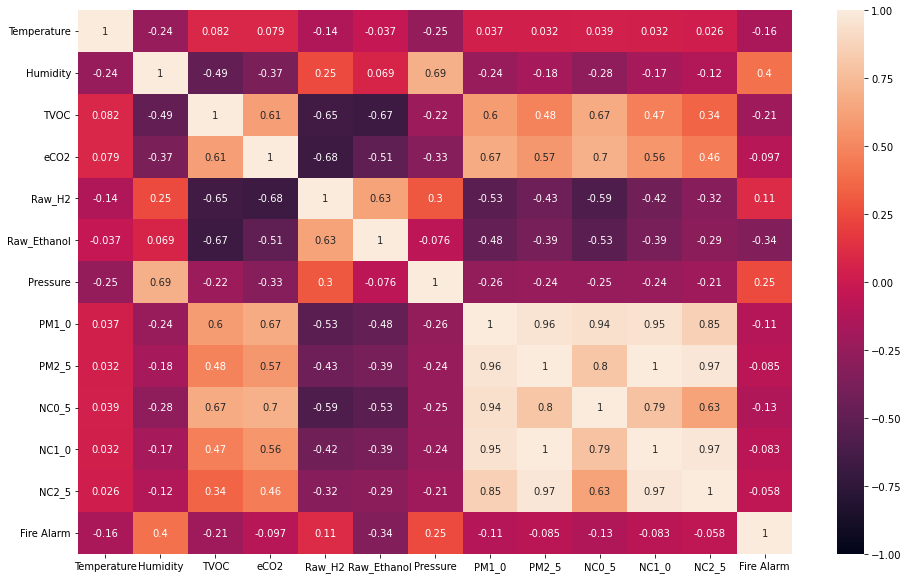

In [23]:
import seaborn as sns

pandasDF = data.toPandas()

plt.figure(figsize=(16, 10))
sns.heatmap(pandasDF.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

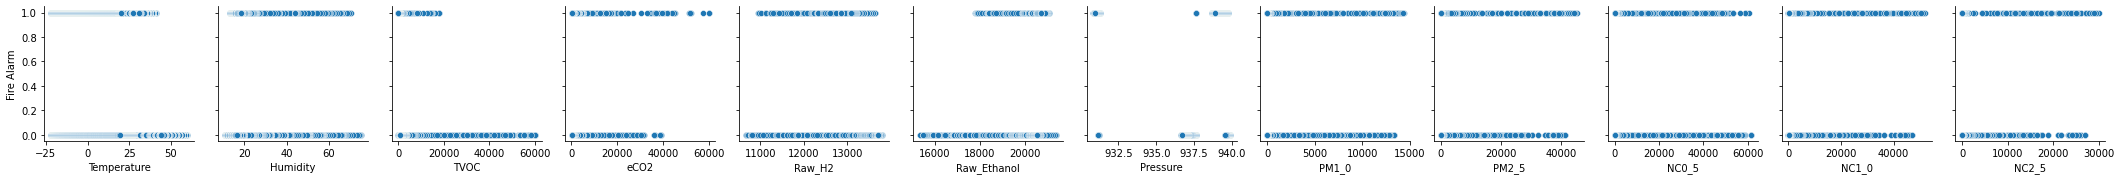

In [24]:
sns.pairplot(pandasDF, x_vars=feature_cols.columns, y_vars = "Fire Alarm")
plt.show()

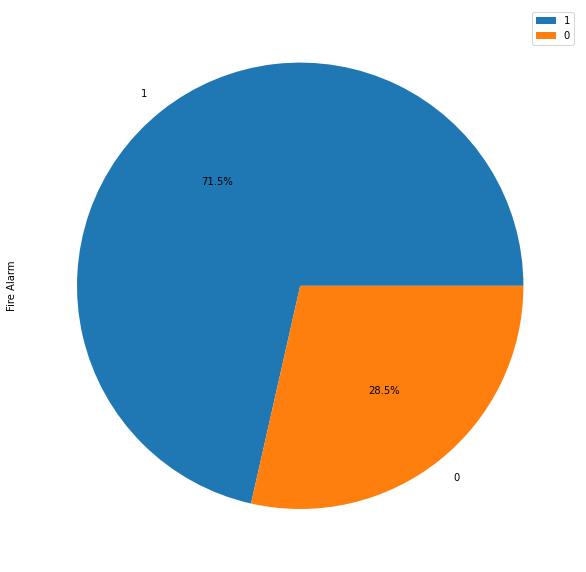

In [25]:
cols = pandasDF.columns
pandasDF['Fire Alarm'].value_counts().plot(kind="pie", autopct="%.1f%%", figsize=(10,15))
plt.legend()
plt.show()

In [26]:
# 2
assembler = VectorAssembler(inputCols=feature_cols.columns, outputCol="features")
data = assembler.transform(data)

# 3
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [27]:
train_data, test_data = data.randomSplit([0.7, 0.3])

In [28]:
lr = LogisticRegression(maxIter=10, regParam=0.001, featuresCol="scaledFeatures", labelCol="Fire Alarm")
lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)

predictions.select('features', 'scaledFeatures', 'Fire Alarm', 'prediction').show(20)
predictions.select('features', 'scaledFeatures', 'Fire Alarm', 'prediction').where('prediction == 0.0').show(20)


evaluator = BinaryClassificationEvaluator(labelCol="Fire Alarm", rawPredictionCol="prediction")
evaluator.evaluate(predictions)

+--------------------+--------------------+----------+----------+
|            features|      scaledFeatures|Fire Alarm|prediction|
+--------------------+--------------------+----------+----------+
|[-22.01,47.72,140...|[-2.6449543621133...|         1|       1.0|
|[-22.01,47.78,136...|[-2.6449543621133...|         1|       1.0|
|[-22.01,48.11,137...|[-2.6449543621133...|         1|       1.0|
|[-22.01,49.24,140...|[-2.6449543621133...|         1|       1.0|
|[-22.01,50.07,140...|[-2.6449543621133...|         1|       1.0|
|[-22.01,50.67,142...|[-2.6449543621133...|         1|       1.0|
|[-22.009,52.01,13...|[-2.6448847221749...|         1|       1.0|
|[-22.009,52.54,14...|[-2.6448847221749...|         1|       1.0|
|[-22.008,49.02,13...|[-2.6448150822364...|         1|       1.0|
|[-22.007,50.54,12...|[-2.6447454422979...|         1|       1.0|
|[-22.006,53.46,13...|[-2.6446758023594...|         1|       1.0|
|[-22.005,54.28,12...|[-2.6446061624209...|         1|       1.0|
|[-22.004,

0.8479191016103494

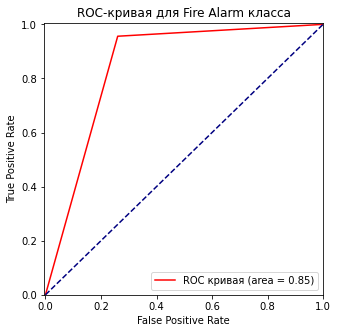

In [29]:
from sklearn.metrics import roc_curve, auc

def show_ROC(y_test, y_predict): 
    fpr, tpr, treshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.rcParams.update({'figure.figsize': (5, 5)})
    plt.plot(fpr, tpr, color='red',
             label='ROC кривая (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.005])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-кривая для {i} класса')
    plt.legend(loc="lower right")
    plt.show()
        
y_test = predictions.select("Fire Alarm").collect()
y_pred = predictions.select("prediction").collect()

show_ROC(y_test, y_pred)
    

In [30]:
from pyspark.ml.classification import LinearSVC

svc = LinearSVC(featuresCol="scaledFeatures", labelCol="Fire Alarm")
svc_model = svc.fit(train_data)

predictions = svc_model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="Fire Alarm", rawPredictionCol="prediction")
evaluator.evaluate(predictions)

0.8460116856940147

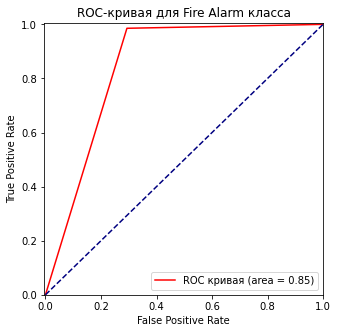

In [31]:
y_test = predictions.select("Fire Alarm").collect()
y_pred = predictions.select("prediction").collect()

show_ROC(y_test, y_pred)

In [32]:
from pyspark.ml.classification import DecisionTreeClassifier

DTT = DecisionTreeClassifier(featuresCol="scaledFeatures", labelCol="Fire Alarm")
DTT_model = DTT.fit(train_data)
predictions = DTT_model.transform(test_data)

predictions.select('features', 'scaledFeatures', 'Fire Alarm', 'prediction').show(20)
predictions.select('features', 'scaledFeatures', 'Fire Alarm', 'prediction').where('prediction == 0.0').show(20)

evaluator = BinaryClassificationEvaluator(labelCol="Fire Alarm", rawPredictionCol="prediction")
evaluator.evaluate(predictions)

+--------------------+--------------------+----------+----------+
|            features|      scaledFeatures|Fire Alarm|prediction|
+--------------------+--------------------+----------+----------+
|[-22.01,47.72,140...|[-2.6449543621133...|         1|       1.0|
|[-22.01,47.78,136...|[-2.6449543621133...|         1|       1.0|
|[-22.01,48.11,137...|[-2.6449543621133...|         1|       1.0|
|[-22.01,49.24,140...|[-2.6449543621133...|         1|       1.0|
|[-22.01,50.07,140...|[-2.6449543621133...|         1|       1.0|
|[-22.01,50.67,142...|[-2.6449543621133...|         1|       1.0|
|[-22.009,52.01,13...|[-2.6448847221749...|         1|       1.0|
|[-22.009,52.54,14...|[-2.6448847221749...|         1|       1.0|
|[-22.008,49.02,13...|[-2.6448150822364...|         1|       1.0|
|[-22.007,50.54,12...|[-2.6447454422979...|         1|       1.0|
|[-22.006,53.46,13...|[-2.6446758023594...|         1|       1.0|
|[-22.005,54.28,12...|[-2.6446061624209...|         1|       1.0|
|[-22.004,

0.9885157678166079

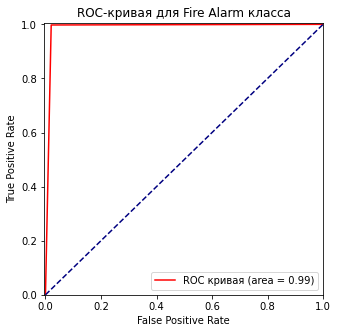

In [33]:
y_test = predictions.select("Fire Alarm").collect()
y_pred = predictions.select("prediction").collect()

show_ROC(y_test, y_pred)

In [34]:
from pyspark.ml.classification import RandomForestClassifier

RFC = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="Fire Alarm")
RFC_model = RFC.fit(train_data)
predictions = RFC_model.transform(test_data)

predictions.select('features', 'scaledFeatures', 'Fire Alarm', 'prediction').show(20)
predictions.select('features', 'scaledFeatures', 'Fire Alarm', 'prediction').where('prediction == 0.0').show(20)

evaluator = BinaryClassificationEvaluator(labelCol="Fire Alarm", rawPredictionCol="prediction")
evaluator.evaluate(predictions)

+--------------------+--------------------+----------+----------+
|            features|      scaledFeatures|Fire Alarm|prediction|
+--------------------+--------------------+----------+----------+
|[-22.01,47.72,140...|[-2.6449543621133...|         1|       1.0|
|[-22.01,47.78,136...|[-2.6449543621133...|         1|       1.0|
|[-22.01,48.11,137...|[-2.6449543621133...|         1|       1.0|
|[-22.01,49.24,140...|[-2.6449543621133...|         1|       1.0|
|[-22.01,50.07,140...|[-2.6449543621133...|         1|       1.0|
|[-22.01,50.67,142...|[-2.6449543621133...|         1|       1.0|
|[-22.009,52.01,13...|[-2.6448847221749...|         1|       1.0|
|[-22.009,52.54,14...|[-2.6448847221749...|         1|       1.0|
|[-22.008,49.02,13...|[-2.6448150822364...|         1|       1.0|
|[-22.007,50.54,12...|[-2.6447454422979...|         1|       1.0|
|[-22.006,53.46,13...|[-2.6446758023594...|         1|       1.0|
|[-22.005,54.28,12...|[-2.6446061624209...|         1|       1.0|
|[-22.004,

0.9923455645207545

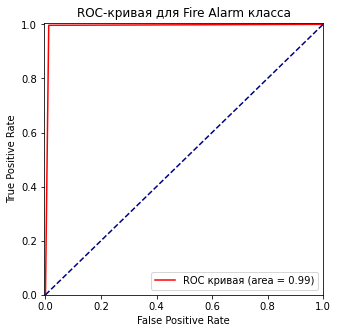

In [35]:
y_test = predictions.select("Fire Alarm").collect()
y_pred = predictions.select("prediction").collect()

show_ROC(y_test, y_pred)